In [1]:
import tensorflow as tf;
import numpy as np;
import matplotlib.pyplot as plt;
print(tf.__version__);
import pandas as pd;

from sklearn.metrics import mean_squared_error;

2.3.0


In [2]:
from constants import *;
from NN_predict_v1 import *;

In [3]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

get_available_gpus()

[]

### The goal of this file:
Try to set up the environment so that all the zip codes are fed into the data

#### Reading the zri csv file

In [4]:
multi_data = pd.read_csv('../data/zri_multifamily_v2.csv');
multi_data = multi_data[multi_data["State"] == "TX"];
multi_data.head()

,zip,City,State,Metro,CountyName,year-month,zri
64296,75001,Addison,TX,Dallas-Fort Worth-Arlington,Dallas County,2014-01,997.0
64297,75001,Addison,TX,Dallas-Fort Worth-Arlington,Dallas County,2014-02,997.0
64298,75001,Addison,TX,Dallas-Fort Worth-Arlington,Dallas County,2014-03,997.0
64299,75001,Addison,TX,Dallas-Fort Worth-Arlington,Dallas County,2014-04,997.0
64300,75001,Addison,TX,Dallas-Fort Worth-Arlington,Dallas County,2014-05,997.0


In [5]:
# In our first try, just look at the zip codes in NY.
multi_NY = multi_data[multi_data["State"] == "NY"];

#### Segmenting the csv file into tens of thousands of windows

In [6]:
@tf.autograph.experimental.do_not_convert
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [ ]:
# test_NY = multi_data[multi_data["zip"] == 10001];

# single_city_series = np.array(test_NY["zri"])

In [16]:
cities_stats = {};
dataset = windowed_dataset(np.zeros(1), WINDOW_SIZE, BATCH_SIZE, 60);
validset = windowed_dataset(np.zeros(1), WINDOW_SIZE, BATCH_SIZE, 60);

dataset_created = False;
for zip_num in multi_data["zip"].unique():
    test = multi_data[multi_data["zip"] == zip_num];
    single_city_series = np.array(test["zri"]);
    
    single_city_series_mean = single_city_series.mean();
    single_city_series_std = single_city_series.std();
    single_city_series = (single_city_series - single_city_series_mean)/\
    single_city_series_std;
    
    cities_stats[zip_num] = {"mean": single_city_series_mean,
                             "std":single_city_series_std};
    
    single_city_train = single_city_series[:SPLIT];
    single_city_test = single_city_series[SPLIT-WINDOW_SIZE:];
    
    cityset = windowed_dataset(single_city_train, WINDOW_SIZE, BATCH_SIZE, 60);
    cityvalid = windowed_dataset(single_city_test, WINDOW_SIZE, BATCH_SIZE, 60);
    
    dataset = dataset.concatenate(cityset);
    validset = validset.concatenate(cityvalid);

In [ ]:
# i = 0
# for x,y in dataset:
#     i += 1;
# #     print("x = ", x.numpy())
# #     print("y = ", y.numpy())
# i

In [ ]:
# Concatenate tensorflow dataset
# cities_stats

#### Messing up with the Tensorflow models

In [ ]:
tf.keras.backend.clear_session()
# dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
    tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=False)),
    # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=False)),
    #  tf.keras.layers.SimpleRNN(16, return_sequences=True),
    #  tf.keras.layers.SimpleRNN(16, return_sequences=True),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(8, activation="relu"),
#   tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 2.0)
])

model.summary();

optimizer = tf.keras.optimizers.SGD(learning_rate=3e-4, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer="adam",
              metrics=["mae", "mse"])
history = model.fit(dataset, epochs=500, validation_data=validset)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, None, 1)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 32)          192       
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                16640     
_________________________________________________________________
dense (Dense)                (None, 16)                1040      
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
_________________________________________________________________
lambda_1 (Lambda)            (None, 1)                 0

210/210 [==============================] - 4s 21ms/step - loss: 0.0103 - mae: 0.1004 - mse: 0.0205 - val_loss: 0.0187 - val_mae: 0.1296 - val_mse: 0.0377
Epoch 43/500
210/210 [==============================] - 4s 20ms/step - loss: 0.0103 - mae: 0.1003 - mse: 0.0206 - val_loss: 0.0187 - val_mae: 0.1291 - val_mse: 0.0377
Epoch 44/500
210/210 [==============================] - 4s 21ms/step - loss: 0.0102 - mae: 0.1001 - mse: 0.0205 - val_loss: 0.0189 - val_mae: 0.1296 - val_mse: 0.0380
Epoch 45/500
210/210 [==============================] - 4s 20ms/step - loss: 0.0103 - mae: 0.1005 - mse: 0.0206 - val_loss: 0.0189 - val_mae: 0.1302 - val_mse: 0.0381
Epoch 46/500
210/210 [==============================] - 4s 21ms/step - loss: 0.0102 - mae: 0.0999 - mse: 0.0204 - val_loss: 0.0185 - val_mae: 0.1281 - val_mse: 0.0374
Epoch 47/500
210/210 [==============================] - 4s 20ms/step - loss: 0.0102 - mae: 0.1001 - mse: 0.0203 - val_loss: 0.0190 - val_mae: 0.1303 - val_mse: 0.0383
Epoch 48/50

210/210 [==============================] - 4s 20ms/step - loss: 0.0090 - mae: 0.0956 - mse: 0.0179 - val_loss: 0.0190 - val_mae: 0.1312 - val_mse: 0.0383
Epoch 92/500
210/210 [==============================] - 4s 20ms/step - loss: 0.0089 - mae: 0.0956 - mse: 0.0178 - val_loss: 0.0191 - val_mae: 0.1311 - val_mse: 0.0383
Epoch 93/500
210/210 [==============================] - 4s 21ms/step - loss: 0.0089 - mae: 0.0957 - mse: 0.0178 - val_loss: 0.0197 - val_mae: 0.1342 - val_mse: 0.0396
Epoch 94/500
210/210 [==============================] - 4s 20ms/step - loss: 0.0088 - mae: 0.0952 - mse: 0.0176 - val_loss: 0.0193 - val_mae: 0.1327 - val_mse: 0.0388
Epoch 95/500
210/210 [==============================] - 4s 21ms/step - loss: 0.0087 - mae: 0.0949 - mse: 0.0175 - val_loss: 0.0192 - val_mae: 0.1323 - val_mse: 0.0387
Epoch 96/500
210/210 [==============================] - 4s 20ms/step - loss: 0.0087 - mae: 0.0948 - mse: 0.0175 - val_loss: 0.0192 - val_mae: 0.1318 - val_mse: 0.0386
Epoch 97/50

210/210 [==============================] - 4s 20ms/step - loss: 0.0069 - mae: 0.0866 - mse: 0.0138 - val_loss: 0.0214 - val_mae: 0.1366 - val_mse: 0.0432
Epoch 140/500
210/210 [==============================] - 4s 20ms/step - loss: 0.0070 - mae: 0.0874 - mse: 0.0139 - val_loss: 0.0214 - val_mae: 0.1365 - val_mse: 0.0432
Epoch 141/500
210/210 [==============================] - 4s 21ms/step - loss: 0.0069 - mae: 0.0868 - mse: 0.0137 - val_loss: 0.0215 - val_mae: 0.1364 - val_mse: 0.0434
Epoch 142/500
210/210 [==============================] - 4s 20ms/step - loss: 0.0068 - mae: 0.0861 - mse: 0.0135 - val_loss: 0.0215 - val_mae: 0.1368 - val_mse: 0.0435
Epoch 143/500
210/210 [==============================] - 4s 20ms/step - loss: 0.0067 - mae: 0.0857 - mse: 0.0135 - val_loss: 0.0218 - val_mae: 0.1375 - val_mse: 0.0441
Epoch 144/500
210/210 [==============================] - 4s 20ms/step - loss: 0.0069 - mae: 0.0869 - mse: 0.0137 - val_loss: 0.0218 - val_mae: 0.1387 - val_mse: 0.0440
Epoch 

#### Prediction, checking results

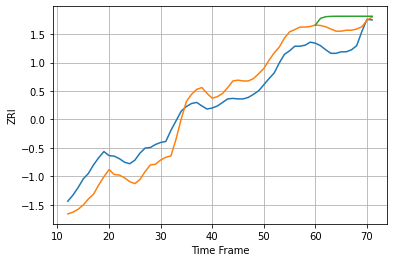

75001 36.150675399819626 35.74178838857037 56.11408481560067


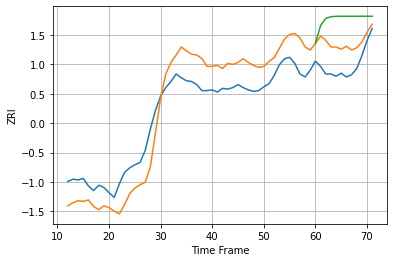

75010 32.213939849659816 31.398547365604 63.039529757035325


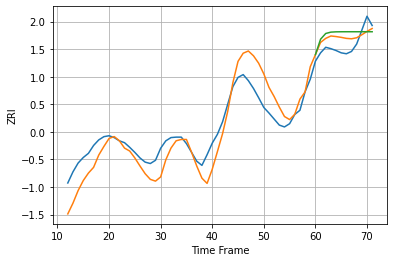

75013 39.1590033886676 24.310987300261477 32.925269272106874


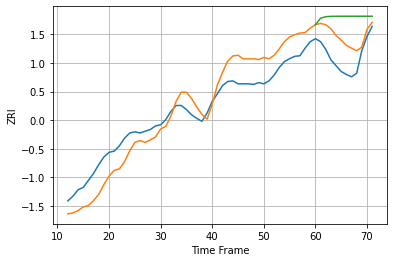

75024 32.08563545188123 38.98432883490146 71.78034483338567


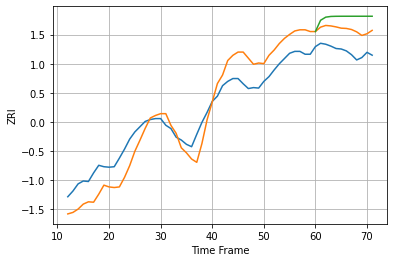

75039 42.0365839233299 45.03580940387457 70.63042853175489


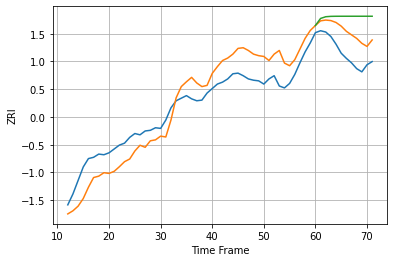

75050 30.883635635739672 34.21653863727577 58.899218750973


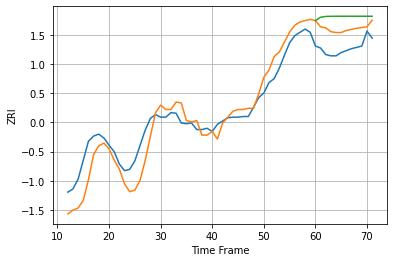

75052 24.951175390800948 31.817488409548943 49.04830860067835


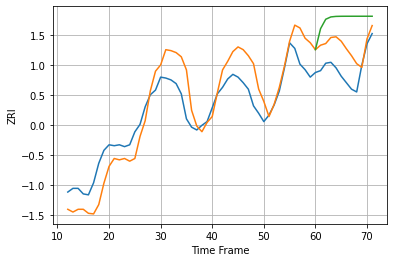

75056 25.27832496878441 27.021514961333548 55.21575816467049


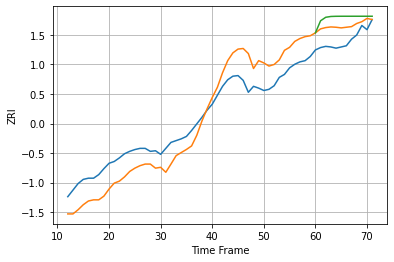

75063 35.359836835467995 26.379966708489732 39.8224832222493


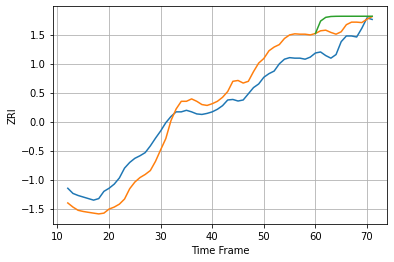

75067 35.766289000934 31.7753333248533 50.030412028339455


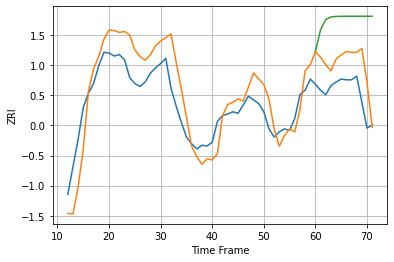

75070 32.93381109376934 41.621490001921096 100.39203821969105


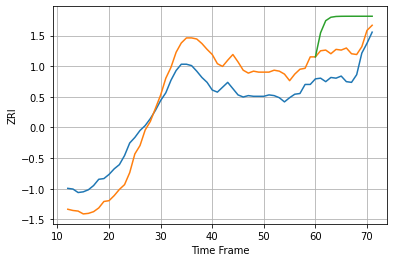

75074 34.468386975265496 34.411719484180296 73.68017311411094


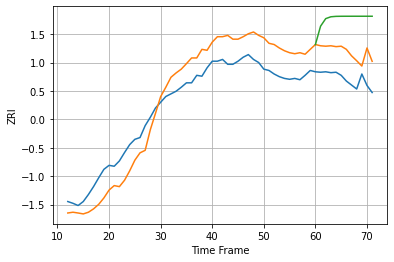

75081 50.228217793415475 63.51618924216689 136.58925976966853


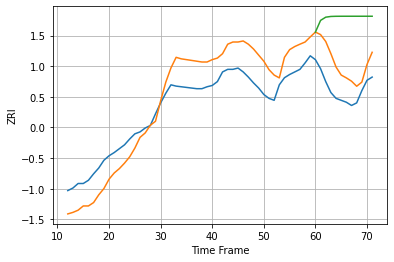

75093 36.73133647509181 42.611258425578896 112.3879078799261


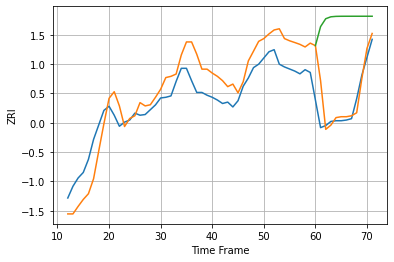

75201 32.463333911798294 31.218098765488072 126.30891549236861


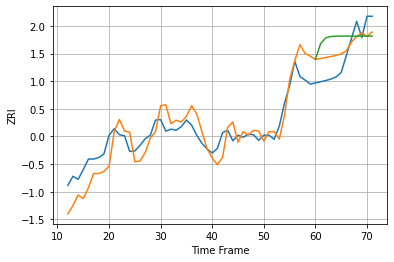

75202 32.57260268524457 35.53481157544393 57.011807673504784


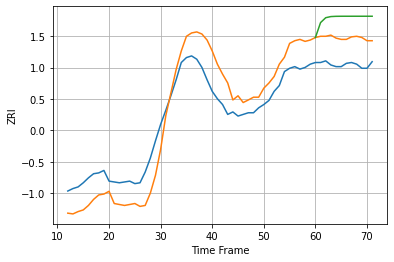

75204 29.173597348953678 32.34008895375687 56.09872806881666


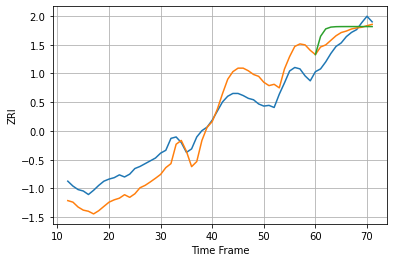

75206 29.08775741602608 16.53404899041104 26.266172905520122


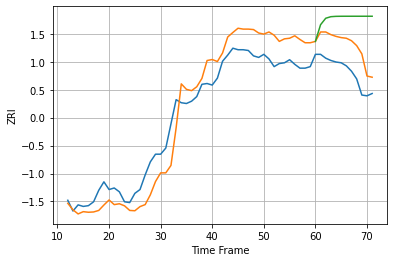

75214 27.001124396004528 34.577830634500486 72.03280632481209


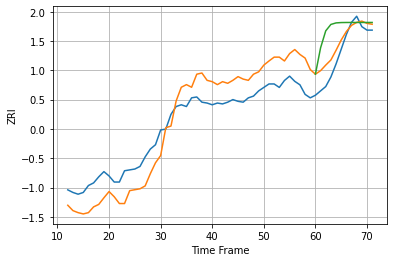

75219 26.216096788125025 15.01959154372392 34.68005892792906


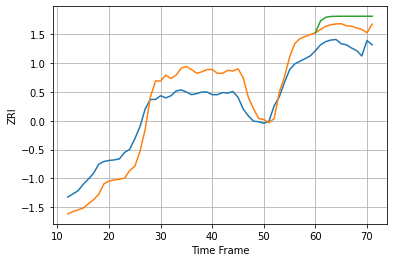

75235 38.54510265828284 35.31917523323571 52.58046962709821


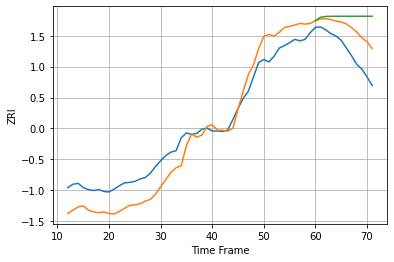

75243 39.5322219757729 50.302316977996774 80.09956046713327


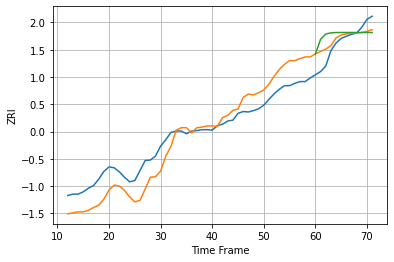

75244 38.823390189944895 25.062848011149626 37.36698244709473


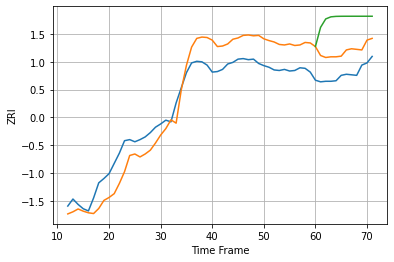

75248 39.90971184593229 44.56106184590635 101.73750223909923


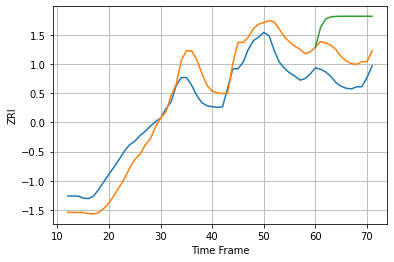

75287 41.424585214701295 50.215286681899165 118.6575617348922


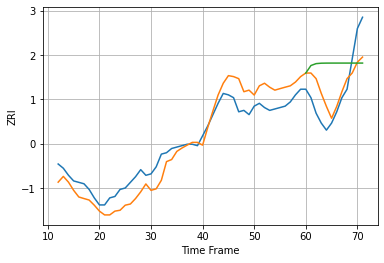

75703 11.225983139079688 16.652922651782703 31.02234318780775


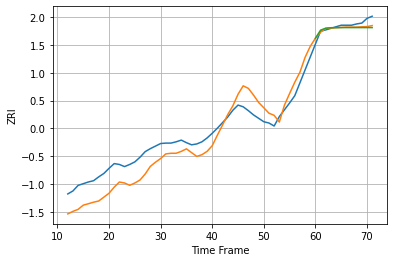

76006 37.78139417908928 10.237391565793706 11.788119584298423


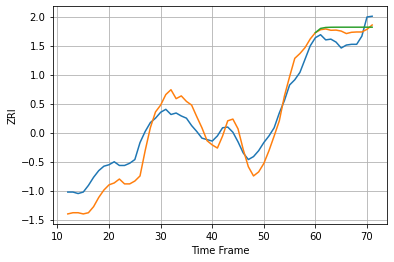

76010 23.4049684904234 14.383410079479514 18.4411597820917


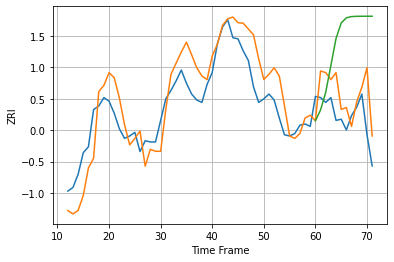

76012 21.162448205829442 25.244044636845473 72.66968223266615


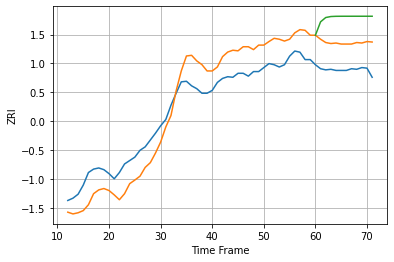

76015 39.67856715992456 48.47361363942531 90.56597357039867


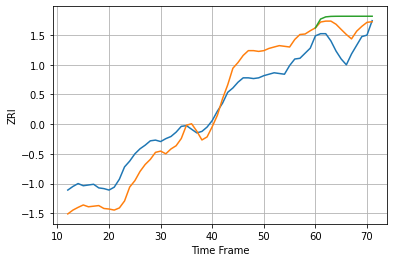

76017 27.8336351248103 25.07631361353911 39.09645013656097


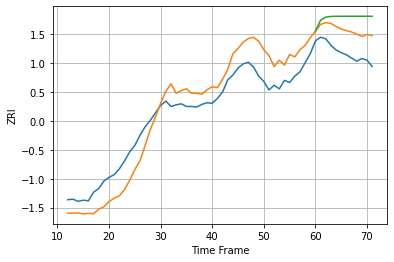

76039 38.213186592166565 42.63444857205322 67.73099008851983


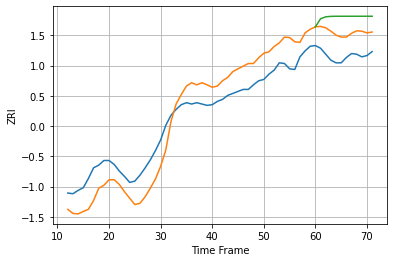

76051 33.0879824171229 35.648518937585195 58.06502053344107


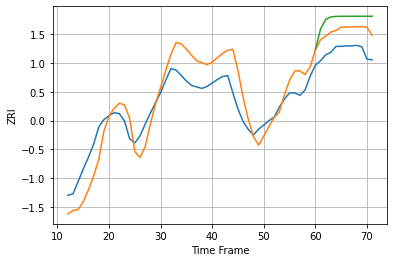

76107 42.980086832639564 41.902401166251636 66.07889738443669


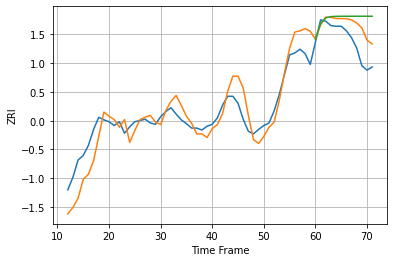

76108 25.80528777630692 29.345814151270933 45.15458715131207


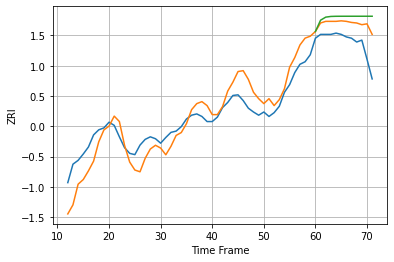

76116 26.812153761173676 32.599027820699575 43.98843996239376


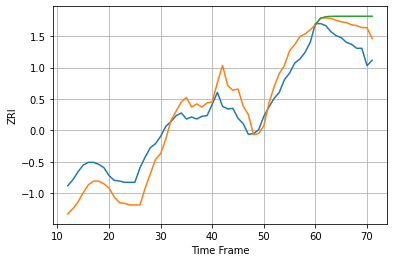

76132 29.690483038995524 28.658148187653595 41.24574514828549


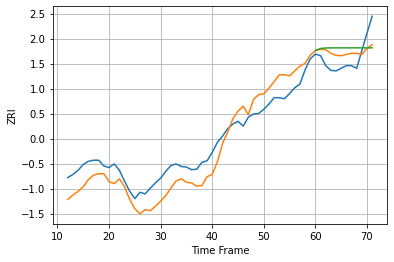

76133 32.13663139006837 27.831446943016353 35.19391014315903


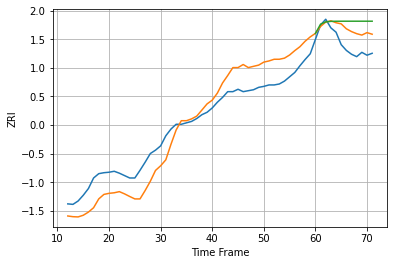

76137 41.37441725595331 34.57678282486583 50.762165820108606


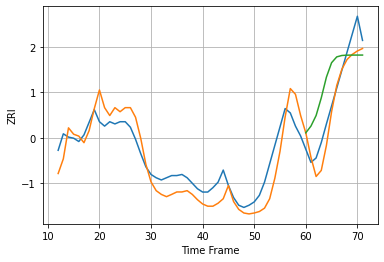

76522 15.962988268379677 15.867713678777703 29.72341838469128


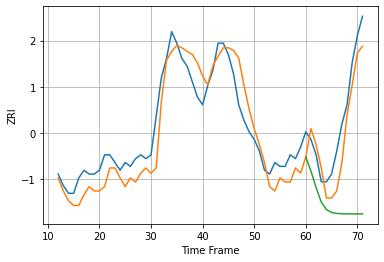

76543 5.346301580170035 6.180969536181689 26.313754401731053


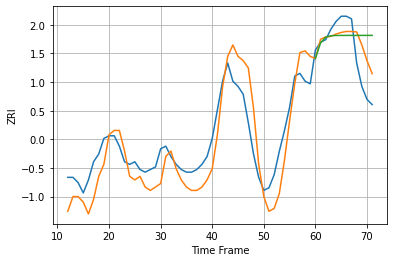

76549 9.293453506434872 8.671758720312157 12.943700479677103


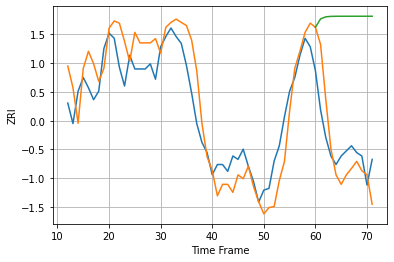

77004 15.994974847345878 18.612108949488015 77.09789669480246


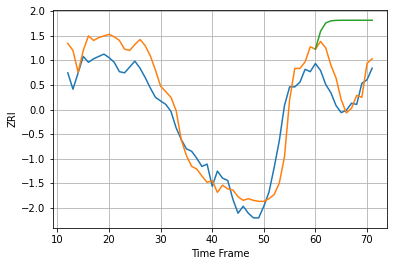

77006 17.913085713534485 16.994615618879404 59.62623297158071


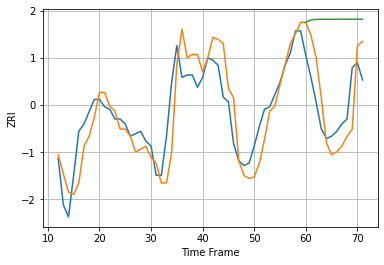

77007 10.096319230693107 13.411263480608415 35.87902616231892


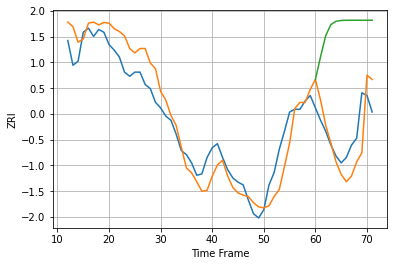

77019 14.621930385988122 19.48789286925501 77.01557070321088


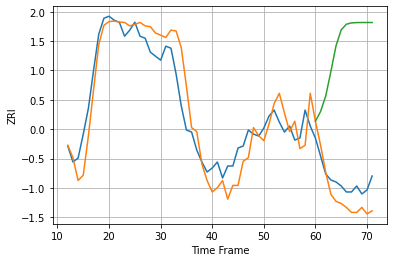

77027 11.041068957198304 9.820220553187228 68.95071056568898


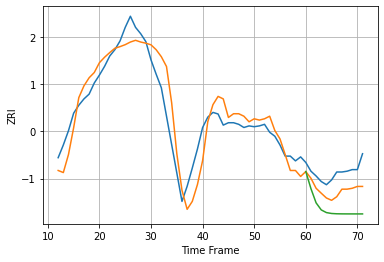

77042 23.593331663922886 22.80572426513196 46.924498329528625


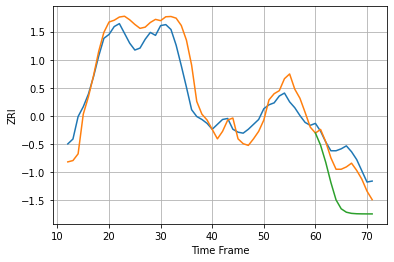

77054 18.218451950365292 13.514328493407307 44.58195344441821


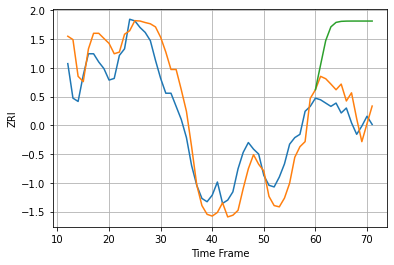

77056 15.196751567803338 11.848472311486288 52.075779711019734


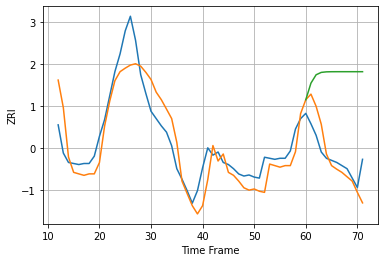

77057 20.250364406123204 19.17124068170809 81.08666578599444


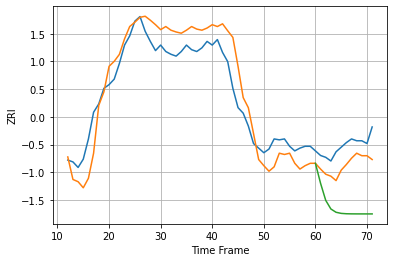

77063 23.024711666381155 21.398340108656317 68.03433936879333


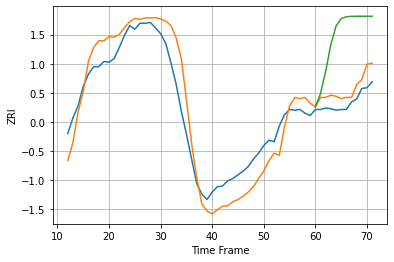

77077 28.653425932539257 17.714447268375853 93.11022446857693


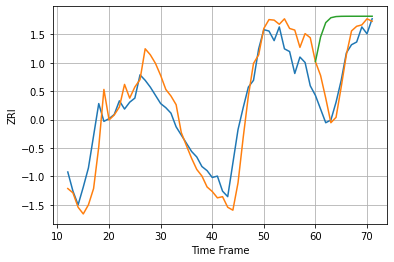

77090 17.85855912436143 13.052838623255784 42.963032911330686


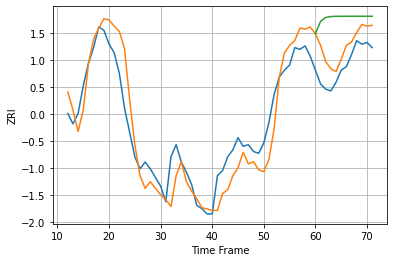

77098 13.219147180734312 13.047232140936183 28.99122142318812


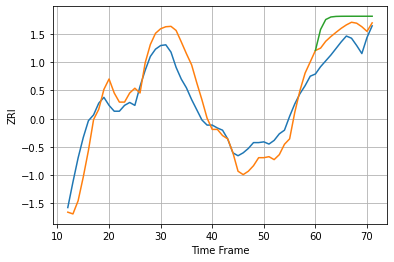

77380 27.564607591580714 24.096675185047914 40.426413160684824


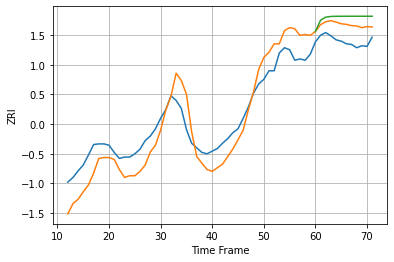

77429 30.41153355677785 24.864049273535 36.375023397025856


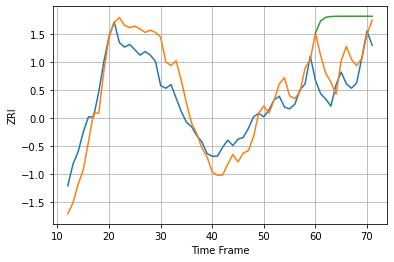

77494 23.885885016472127 29.426620262158075 69.9316418734723


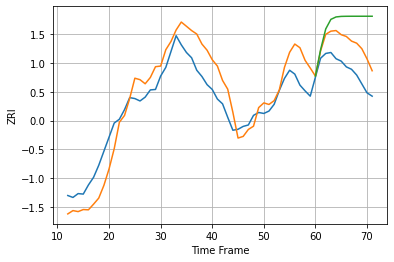

77550 45.34383339652422 54.27656302670086 106.21602025052961


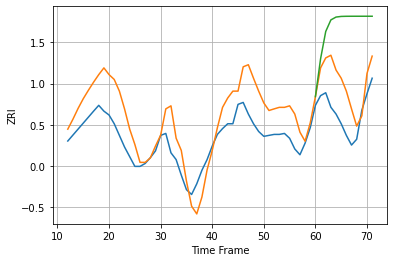

77584 28.3904585676805 34.15362880630057 93.40846986905179


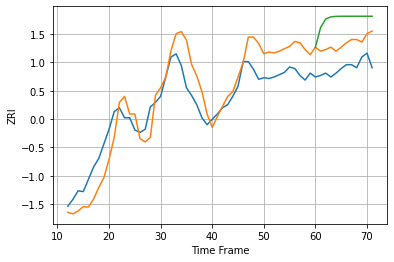

77598 29.261246932725765 32.96638116966687 63.5709400169521


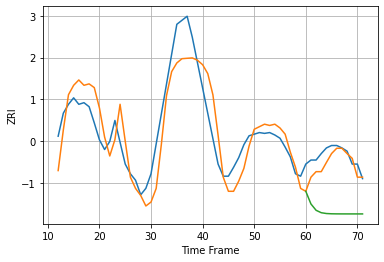

77840 28.525551702000453 15.944024883726561 68.58909724528652


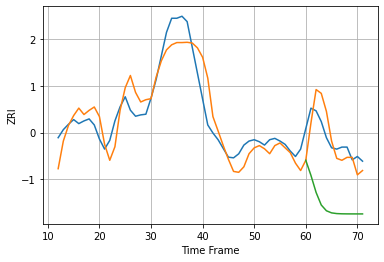

77845 26.664384714902184 27.220735961353352 96.94859547764113


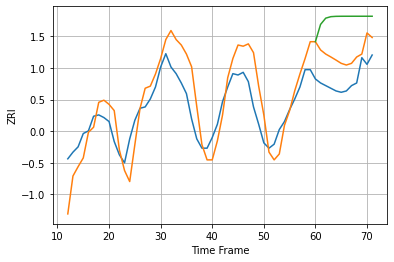

78130 19.02547012449725 21.02737989714918 46.64553768324361


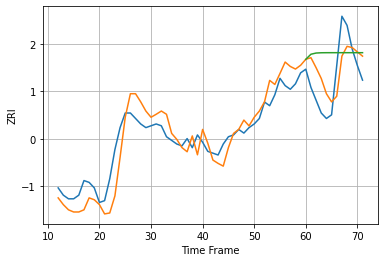

78201 9.076571153089617 13.921463968557287 21.457720742163726


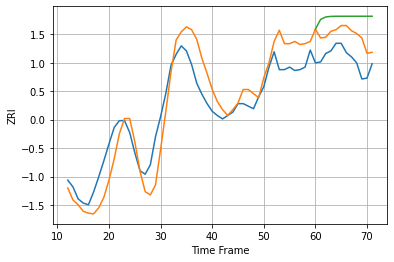

78209 26.20903583734152 29.54204226376022 50.49054586746196


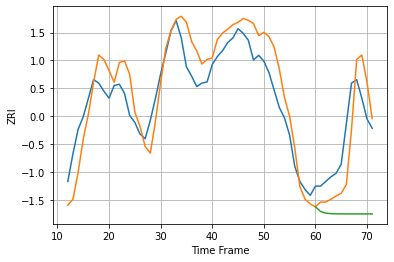

78210 21.195370519880644 27.914642058751983 70.79903969852388


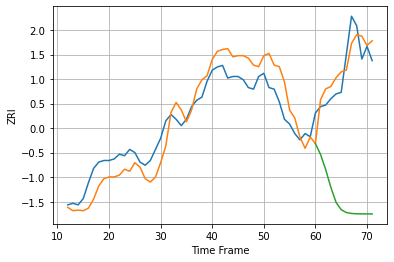

78212 12.199596454582707 11.60366629828089 84.57478115228652


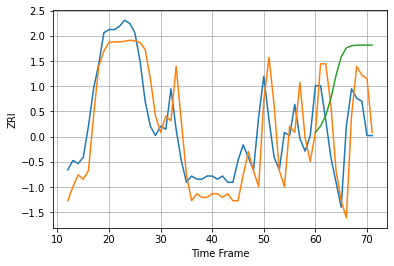

78213 9.785876359438907 13.981818927141408 24.799066261122586


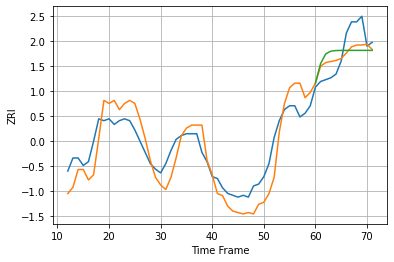

78216 10.392854316677031 9.07638801913819 11.532299046248204


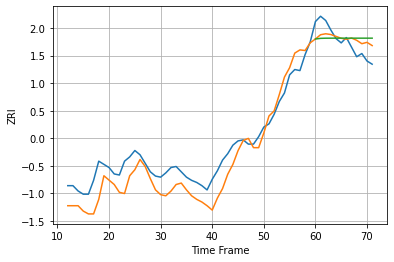

78229 16.47826447239282 12.159129420042879 14.971828163204155


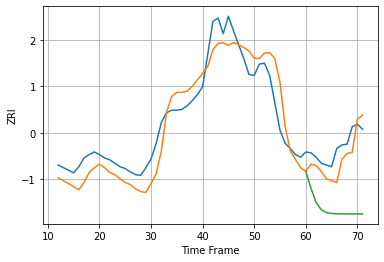

78233 21.869288330498406 19.209945748773567 71.9112501629971


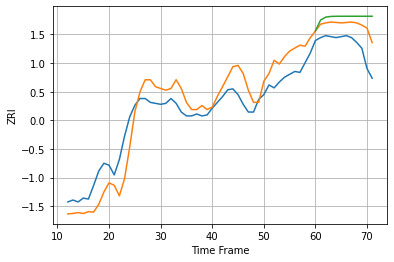

78240 20.323188939365473 21.754483510725592 31.522348161232774


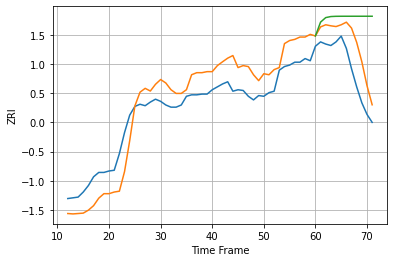

78249 30.38014335328232 36.89804734925144 79.85559543829332


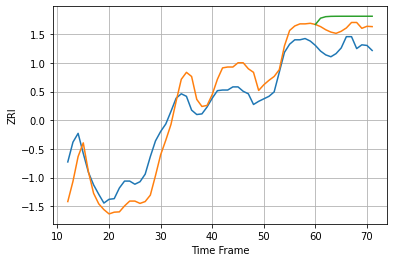

78256 32.4805828423177 32.95432956209816 49.81663262479679


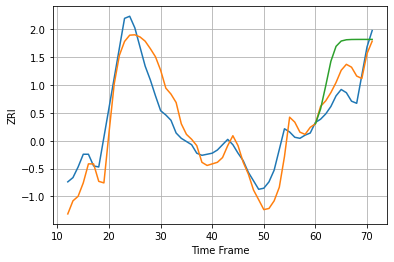

78521 19.527268304265966 17.09013192760214 38.29786953140839


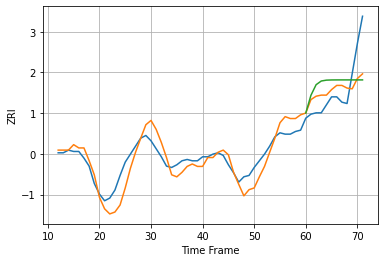

78550 9.197573637773326 17.333020066328746 21.488649218037963


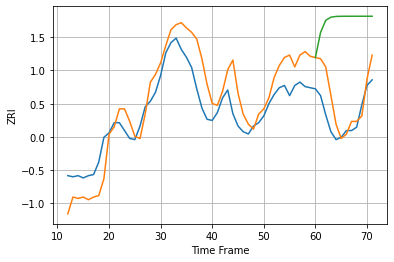

78613 22.126488137207073 21.584207676793095 85.6676693139412


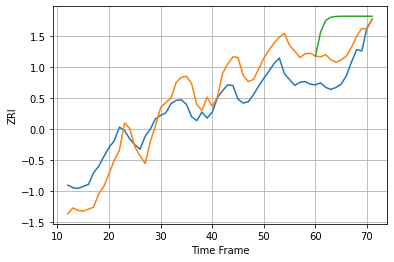

78660 35.14487233996009 34.24830323519786 77.84124553003468


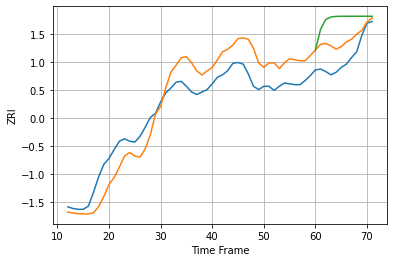

78664 26.120849914529423 24.36511029187718 49.15664489601218


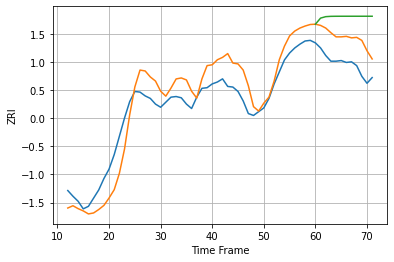

78666 30.930853576252243 41.73860129087664 75.52828958208669


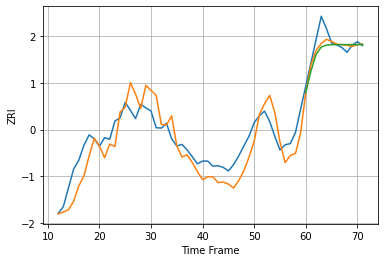

78701 45.56199263443888 24.11774201391683 29.472588627664674


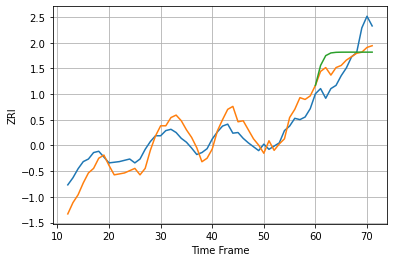

78702 21.08340185580819 28.017899421070585 40.40972550346977


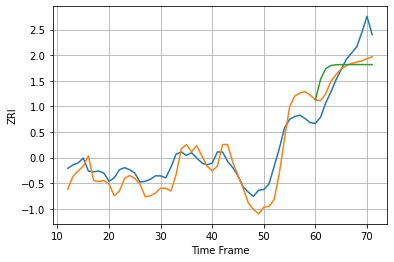

78703 22.402818646399837 28.455604606119078 39.791433495706926


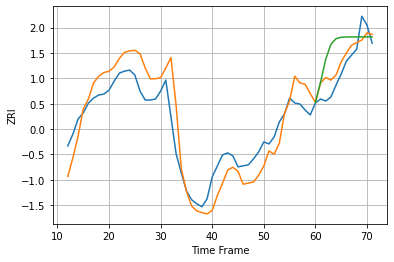

78704 22.174365457033353 13.754767490763044 28.91345488586058


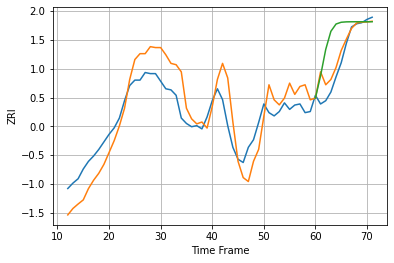

78705 21.313328032515006 11.086804627592851 29.26497559731752


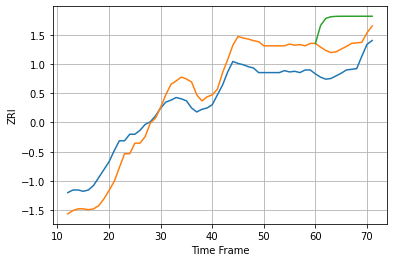

78728 32.546262461358566 36.62683203259209 75.38856987240297


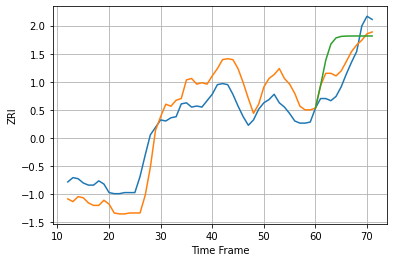

78729 21.06065966862941 15.300152222303328 31.875558011129556


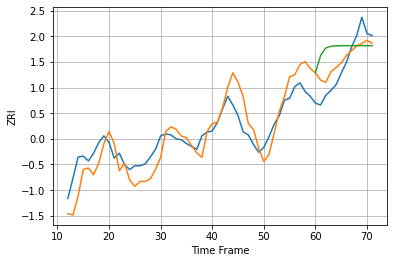

78735 18.42145454126949 17.48990993946193 31.80763264366161


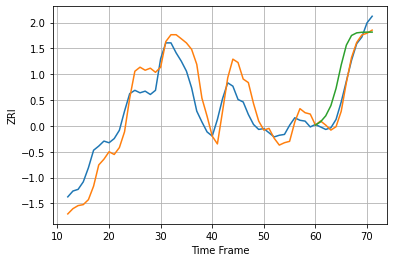

78741 24.49731320428847 7.874468703162287 25.560234803966587


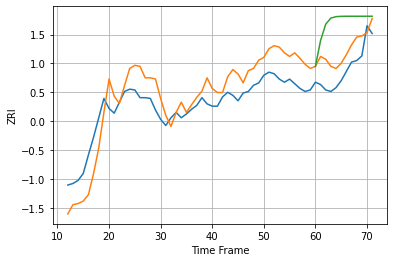

78744 28.82962710017417 26.625587187677983 64.84086397375788


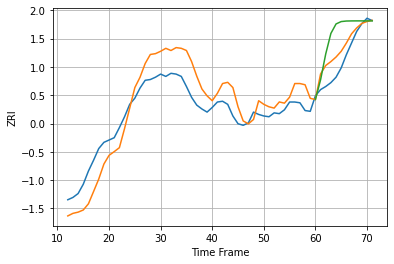

78745 25.877043907752206 16.926606437549815 37.80995413906767


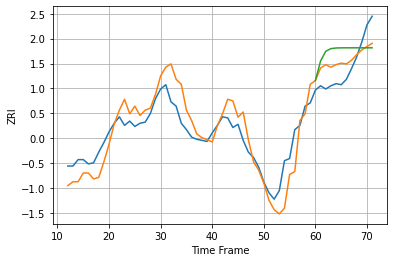

78746 17.426429517896864 16.53811191124469 25.895026570781848


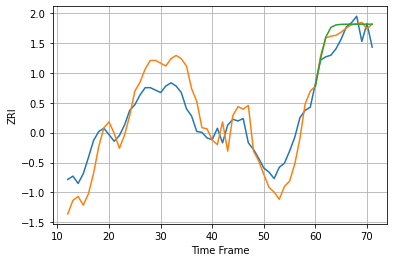

78748 27.201161086902022 15.701766319234203 18.948717443396554


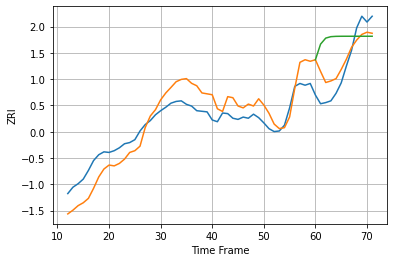

78749 29.765868274916542 33.104042676357906 71.61302803984563


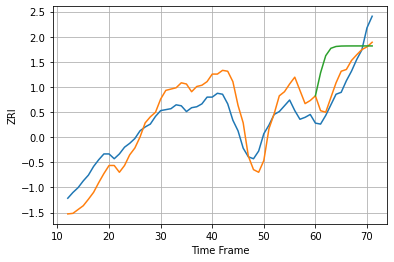

78750 20.392054718557805 16.051053571596185 40.024399364947826


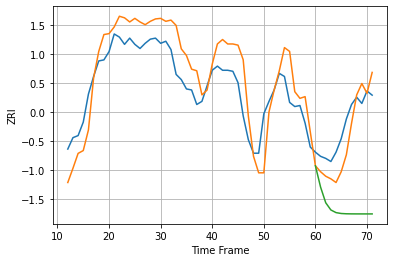

78751 25.685893788396886 20.862013818274036 83.84135477697842


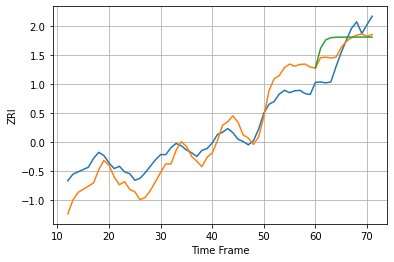

78752 36.986658078530475 33.259974159923715 52.44427097164866


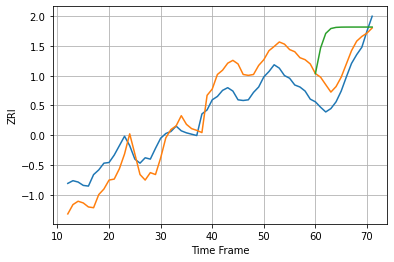

78753 32.7291655303807 26.79630278511561 76.15035557410945


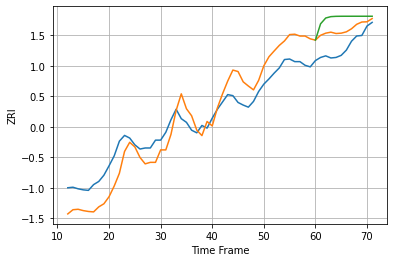

78754 38.671999802932994 34.85656473962285 56.72206921844749


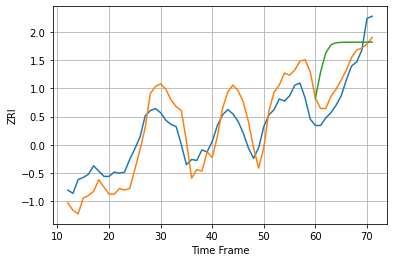

78757 20.957578960362113 15.70531989496408 41.179231962484195


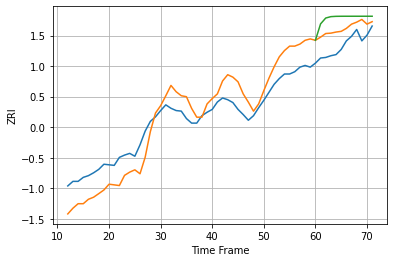

78758 35.35654557106676 31.289707225030195 49.474806759329546


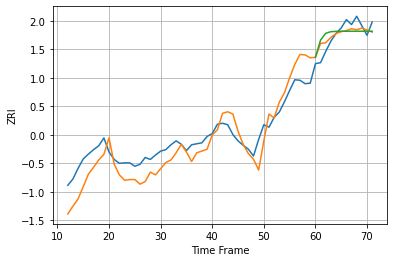

78759 34.27013765192975 18.375027185895455 22.99393494054185


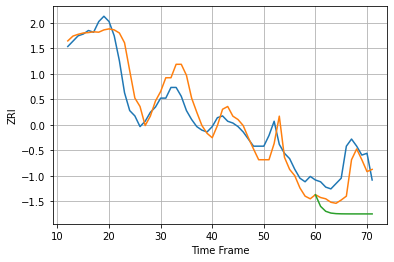

79912 9.587692673127167 11.523469914234331 26.76375462960486


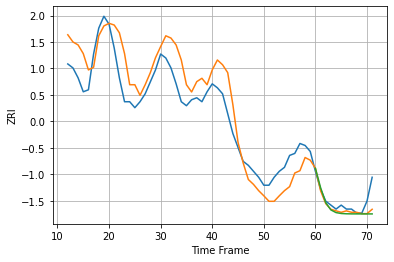

79936 11.755887731212864 5.204946506350093 5.938524050465303


In [14]:
time_train = list(range(SPLIT));
time_test = list(range(SPLIT, len(single_city_series)))

score_dict = {"zip":[], "RMSE_train":[], "RMSE_test":[], "RMSE_pure":[], "forecast":[]};

for zip_num in multi_data["zip"].unique():
    test = multi_data[multi_data["zip"] == zip_num];
    city_mean = cities_stats[zip_num]["mean"];
    city_std = cities_stats[zip_num]["std"];
    
    single_city_series = (np.array(test["zri"]) - city_mean)/city_std;
    
    forecast = []
    results = []
    for time in range(len(single_city_series) - WINDOW_SIZE):
        forecast.append(model.predict(single_city_series[time:time + WINDOW_SIZE, np.newaxis]))

    #print(forecast)

    # forecast = forecast[SPLIT - WINDOW_SIZE:]
    # print(np.array(forecast).shape)
    results = np.array(forecast)[:, -1, 0]
    actual = single_city_series[WINDOW_SIZE:]
    time_actual = range(WINDOW_SIZE, len(single_city_series));

    pure_forecast = list(single_city_series[SPLIT - WINDOW_SIZE: SPLIT]);
    for time in range(SPLIT, len(single_city_series)):
        # print(model.predict(pure_forecast[-WINDOW_SIZE:][np.newaxis]))
        pure_forecast.append(np.array(model.predict(np.array(pure_forecast[-WINDOW_SIZE:])[..., np.newaxis]))[-1,0])
    pure_forecast = np.array(pure_forecast[WINDOW_SIZE:]);
    
    M_train = mean_squared_error(actual[:-TEST_LENGTH], results[:-TEST_LENGTH])**0.5 * city_std;
    M_test = mean_squared_error(actual[-TEST_LENGTH:], results[-TEST_LENGTH:])**0.5 * city_std;
    M_pure = mean_squared_error(actual[-TEST_LENGTH:], pure_forecast[-TEST_LENGTH:])**0.5 * city_std;
    forecast = list(np.array(pure_forecast[-TEST_LENGTH:]) * city_std + city_mean);
    
    plot_series(time_actual, actual);
    plot_series(time_actual, results);
    plot_series(time_test, pure_forecast);
    plt.show();
    
    score_dict["zip"].append(zip_num);
    score_dict["RMSE_train"].append(M_train);
    score_dict["RMSE_test"].append(M_test);
    score_dict["RMSE_pure"].append(M_pure);
    score_dict["forecast"].append(forecast);
    print(zip_num, M_train, M_test, M_pure)


In [15]:
sum(score_dict["RMSE_pure"])/len(score_dict["RMSE_pure"])

54.66157117734111

In [ ]:
#score_dict["zip"]

In [ ]:
NN_1_summary = pd.read_csv('./NN_1_summary.csv', index_col = 0);


In [ ]:
NN_1_summary[NN_1_summary.index.isin(score_dict["zip"])]["RMSE_pure"].mean()

### Then, we need to tune the hyperparameters...

#### Starting from here, we need a train/validation/test split

#### Wrapping to GridSearchCV in sklearn...

Plan: use the `tf.keras.wrappers.scikit_learn.KerasRegressor` wrapper

https://www.tensorflow.org/api_docs/python/tf/keras/wrappers/scikit_learn/KerasRegressor

In [ ]:
# model.save('saved_model/my_model')
# new_model = tf.keras.models.load_model('saved_model/my_model')